In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/affectnet/affectnet7')
training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42


In [3]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [4]:
import keras

print('---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=True,
                                                                seed=SEED)

class_frequencies = compute_class_frequencies(training_set_path)


2024-03-19 22:36:45.933830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 22:36:45.954655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 22:36:45.954675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 22:36:45.955212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 22:36:45.958860: I tensorflow/core/platform/cpu_feature_guar

---TRAINING SET---
Found 281241 files belonging to 7 classes.


2024-03-19 22:36:49.303106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 22:36:49.320986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-19 22:36:49.321100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0 - Neutral   :    74494 images
1 - Happy     :   134035 images
2 - Sad       :    25079 images
3 - Surprise  :    13710 images
4 - Fear      :     5998 images
5 - Disgust   :     3423 images
6 - Anger     :    24502 images


In [5]:
print('---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=True,
                                                                  seed=SEED)

compute_class_frequencies(validation_set_path)


---VALIDATION SET---
Found 2660 files belonging to 7 classes.
0 - Neutral   :      380 images
1 - Happy     :      380 images
2 - Sad       :      380 images
3 - Surprise  :      380 images
4 - Fear      :      380 images
5 - Disgust   :      380 images
6 - Anger     :      380 images


{0: 380, 1: 380, 2: 380, 3: 380, 4: 380, 5: 380, 6: 380}

In [6]:
total_num_samples = sum(class_frequencies.values())
inverse_class_frequencies = {class_id: 1 / (frequency / total_num_samples) for class_id, frequency in
                             class_frequencies.items()}

total_inverse_class_frequencies = sum(inverse_class_frequencies.values())
class_weights = {class_id: freq / total_inverse_class_frequencies for class_id, freq in
                 inverse_class_frequencies.items()}

print(class_weights)


{0: 0.021194246175344964, 1: 0.01177934251938783, 2: 0.06295482972152588, 3: 0.11516004191000347, 4: 0.26322843857721706, 5: 0.46124574191824347, 6: 0.06443735917827718}


In [7]:
from keras import layers
from keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode="constant"),
    layers.RandomRotation(0.1, fill_mode="constant"),
    layers.RandomZoom(0.1, fill_mode="constant"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
x = data_augmentation(inputs)


In [8]:
from keras.src.applications import EfficientNetB0


def build_model(num_classes, inputs_layer):
    model = EfficientNetB0(include_top=False, input_tensor=inputs_layer, weights="imagenet")

    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(0.2, name="top_dropout1")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNet")
    return model


model = build_model(len(class_frequencies), x)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                   

In [9]:
num_layers = len(model.layers)
for i, layer in enumerate(model.layers):
    print((num_layers - i), layer.name, layer.__class__.__name__)
    if isinstance(layer, layers.Dropout):
        print(f'Dropout Rate {layer.rate}')

242 input_1 InputLayer
241 sequential Sequential
240 rescaling Rescaling
239 normalization Normalization
238 rescaling_1 Rescaling
237 stem_conv_pad ZeroPadding2D
236 stem_conv Conv2D
235 stem_bn BatchNormalization
234 stem_activation Activation
233 block1a_dwconv DepthwiseConv2D
232 block1a_bn BatchNormalization
231 block1a_activation Activation
230 block1a_se_squeeze GlobalAveragePooling2D
229 block1a_se_reshape Reshape
228 block1a_se_reduce Conv2D
227 block1a_se_expand Conv2D
226 block1a_se_excite Multiply
225 block1a_project_conv Conv2D
224 block1a_project_bn BatchNormalization
223 block2a_expand_conv Conv2D
222 block2a_expand_bn BatchNormalization
221 block2a_expand_activation Activation
220 block2a_dwconv_pad ZeroPadding2D
219 block2a_dwconv DepthwiseConv2D
218 block2a_bn BatchNormalization
217 block2a_activation Activation
216 block2a_se_squeeze GlobalAveragePooling2D
215 block2a_se_reshape Reshape
214 block2a_se_reduce Conv2D
213 block2a_se_expand Conv2D
212 block2a_se_excite M

In [10]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f"affectnet_transfer_imagenet_complete_unfreeze_checkpoints_{timestamp}")
training_histories = []
epoch_counter = 0
epochs_per_phase = [10, 8, 8]
learning_rate_per_phase = [1e-3, 1e-4, 1e-5]

for phase, (epochs, learning_rate) in enumerate(zip(epochs_per_phase, learning_rate_per_phase)):

    print(f'\n---STARTING TRAINING PHASE {phase}')
    print(f'EPOCHS:{epochs} LEARNING_RATE:{learning_rate}')
    checkpoint_filepath = str(checkpoint_dir / f'best_model_phase_{phase}.keras')

    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=False,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True)

    if phase > 0:
        old_checkpoint_filepath = checkpoint_filepath.replace(f'phase_{phase}', f'phase_{phase - 1}')
        print(f'Loading model from {old_checkpoint_filepath}')
        model = load_model(old_checkpoint_filepath)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    hist = model.fit(training_set,
                     epochs=epoch_counter + epochs,
                     validation_data=validation_set,
                     class_weight=class_weights,
                     callbacks=[model_checkpoint_callback],
                     initial_epoch=epoch_counter)

    epoch_counter += epochs
    training_histories.append(hist)



---STARTING TRAINING PHASE 0
EPOCHS:10 LEARNING_RATE:0.001
Epoch 1/10


2024-03-19 22:37:02.256660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-19 22:37:03.841905: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-19 22:37:03.935877: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-19 22:37:04.520527: I external/local_xla/xla/service/service.cc:168] XLA service 0x736cda0b5100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 22:37:04.520542: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-19 22:37:04.526532: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash

8789/8789 [==============================] - 866s 96ms/step - loss: 0.0509 - accuracy: 0.6027 - val_loss: 1.1553 - val_accuracy: 0.5635
Epoch 2/10
8789/8789 [==============================] - 833s 95ms/step - loss: 0.0447 - accuracy: 0.6516 - val_loss: 1.0803 - val_accuracy: 0.5936
Epoch 3/10
8789/8789 [==============================] - 830s 94ms/step - loss: 0.0427 - accuracy: 0.6644 - val_loss: 1.0206 - val_accuracy: 0.6120
Epoch 4/10
8789/8789 [==============================] - 841s 96ms/step - loss: 0.0412 - accuracy: 0.6734 - val_loss: 1.0123 - val_accuracy: 0.6267
Epoch 5/10
8789/8789 [==============================] - 841s 96ms/step - loss: 0.0402 - accuracy: 0.6811 - val_loss: 1.0069 - val_accuracy: 0.6256
Epoch 6/10
8789/8789 [==============================] - 842s 96ms/step - loss: 0.0394 - accuracy: 0.6844 - val_loss: 0.9939 - val_accuracy: 0.6282
Epoch 7/10
8789/8789 [==============================] - 840s 96ms/step - loss: 0.0388 - accuracy: 0.6875 - val_loss: 1.0024 - val

2024-03-20 00:57:14.023542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8789/8789 [==============================] - 849s 95ms/step - loss: 0.0343 - accuracy: 0.7106 - val_loss: 0.9429 - val_accuracy: 0.6496
Epoch 12/18
8789/8789 [==============================] - 827s 94ms/step - loss: 0.0332 - accuracy: 0.7159 - val_loss: 0.9386 - val_accuracy: 0.6545
Epoch 13/18
8789/8789 [==============================] - 830s 94ms/step - loss: 0.0326 - accuracy: 0.7194 - val_loss: 0.9345 - val_accuracy: 0.6571
Epoch 14/18
8789/8789 [==============================] - 830s 94ms/step - loss: 0.0321 - accuracy: 0.7215 - val_loss: 0.9468 - val_accuracy: 0.6564
Epoch 15/18
8789/8789 [==============================] - 831s 95ms/step - loss: 0.0319 - accuracy: 0.7225 - val_loss: 0.9430 - val_accuracy: 0.6568
Epoch 16/18
8789/8789 [==============================] - 832s 95ms/step - loss: 0.0314 - accuracy: 0.7242 - val_loss: 0.9438 - val_accuracy: 0.6564
Epoch 17/18
8789/8789 [==============================] - 834s 95ms/step - loss: 0.0312 - accuracy: 0.7244 - val_loss: 0.9540

2024-03-20 02:48:32.507545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8789/8789 [==============================] - 855s 95ms/step - loss: 0.0321 - accuracy: 0.7206 - val_loss: 0.9328 - val_accuracy: 0.6575
Epoch 20/26
8789/8789 [==============================] - 834s 95ms/step - loss: 0.0320 - accuracy: 0.7217 - val_loss: 0.9307 - val_accuracy: 0.6571
Epoch 21/26
8789/8789 [==============================] - 836s 95ms/step - loss: 0.0320 - accuracy: 0.7228 - val_loss: 0.9322 - val_accuracy: 0.6598
Epoch 22/26
8789/8789 [==============================] - 836s 95ms/step - loss: 0.0319 - accuracy: 0.7226 - val_loss: 0.9338 - val_accuracy: 0.6594
Epoch 23/26
8789/8789 [==============================] - 837s 95ms/step - loss: 0.0317 - accuracy: 0.7229 - val_loss: 0.9334 - val_accuracy: 0.6594
Epoch 24/26
8789/8789 [==============================] - 838s 95ms/step - loss: 0.0317 - accuracy: 0.7239 - val_loss: 0.9338 - val_accuracy: 0.6586
Epoch 25/26
8789/8789 [==============================] - 839s 95ms/step - loss: 0.0316 - accuracy: 0.7239 - val_loss: 0.9332

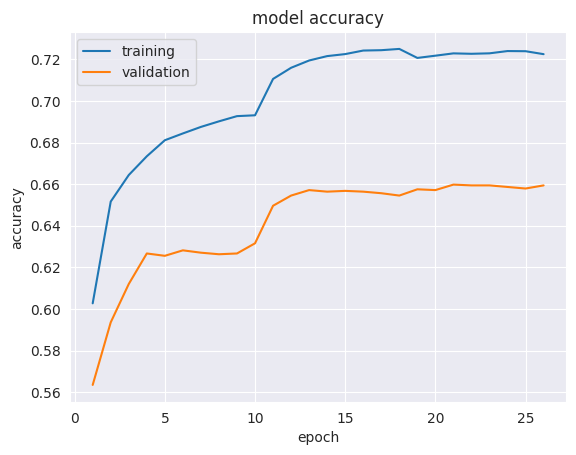

In [11]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hists, checkpoint_dir):
    acc = []
    val_acc = []

    for hist in hists:
        acc += hist.history["accuracy"]
        val_acc += hist.history["val_accuracy"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(training_histories, checkpoint_dir)

In [12]:
import csv


def save_training_history_csv(hists, checkpoint_dir):
    acc = []
    val_acc = []
    for hist in hists:
        acc.extend(hist.history["accuracy"])
        val_acc.extend(hist.history["val_accuracy"])

    epochs = range(1, len(acc) + 1)

    # CSV-Datei schreiben
    with (checkpoint_dir / 'training_history.csv').open(mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'accuracy', 'val_accuracy'])
        for epoch, accuracy, val_accuracy in zip(epochs, acc, val_acc):
            writer.writerow([epoch, accuracy, val_accuracy])


save_training_history_csv(training_histories, checkpoint_dir)


In [13]:
best_checkpoint = str(checkpoint_dir / "best_model_phase_2.keras")
model = load_model(best_checkpoint)

In [14]:
print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)




---TEST SET---
Found 3500 files belonging to 7 classes.
0 - Neutral   :      500 images
1 - Happy     :      500 images
2 - Sad       :      500 images
3 - Surprise  :      500 images
4 - Fear      :      500 images
5 - Disgust   :      500 images
6 - Anger     :      500 images


{0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500}

In [15]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

110/110 [==============================] - 4s 24ms/step - loss: 0.9943 - accuracy: 0.6431
Test accuracy: 0.6431428790092468


In [16]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(test_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values())
print(report)


110/110 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

     Neutral       0.53      0.62      0.57       500
       Happy       0.78      0.87      0.82       500
         Sad       0.64      0.65      0.64       500
    Surprise       0.59      0.63      0.61       500
        Fear       0.70      0.61      0.65       500
     Disgust       0.66      0.59      0.62       500
       Anger       0.62      0.53      0.57       500

    accuracy                           0.64      3500
   macro avg       0.64      0.64      0.64      3500
weighted avg       0.64      0.64      0.64      3500


[[308  32  48  51   6  19  36]
 [ 29 436   4  20   1   8   2]
 [ 71  11 324  19  19  26  30]
 [ 44  34  17 317  63  16   9]
 [ 22   8  37  86 307  23  17]
 [ 29  26  43  21  16 294  71]
 [ 76  11  37  27  26  58 265]]


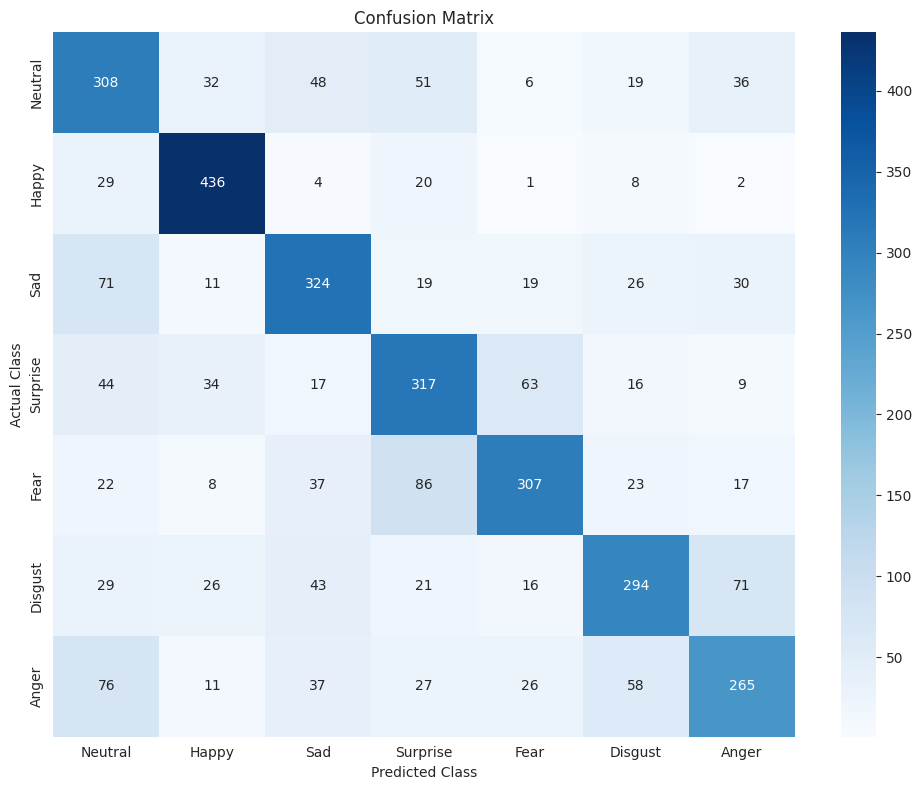

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [18]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [19]:
import shutil

path_to_this_notebook = Path(
    '/home/thor/Desktop/repos/emoji-hero-baseline/affectnet_transfer_imagenet_complete_unfreeze.ipynb')

shutil.copy2(path_to_this_notebook, (checkpoint_dir / path_to_this_notebook.name))

PosixPath('affectnet_transfer_imagenet_complete_unfreeze_checkpoints_20240319-2236/affectnet_transfer_imagenet_complete_unfreeze.ipynb')